#BERT Model

Code is taken from HW 6 Part 3 and 4 and changed slightly.

In [ ]:
import os
import re
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

%matplotlib inline

In [ ]:
import torch
import torchvision.transforms as transforms
from torch.utils.data import random_split
import torch.nn as nn

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
device = get_default_device()
device

device(type='cuda')

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving train.csv to train.csv


In [ ]:
import io

train_df = pd.read_csv(io.BytesIO(uploaded['train.csv']))
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [ ]:
X = train_df.text.values
y = train_df.target.values

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=101)

# Preprocess Text

In [ ]:
import string
import nltk
from nltk.tokenize import word_tokenize

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
def preprocess(tweet):

  special_chars = set(string.punctuation)

  tweet = re.sub('&amp', '&', tweet) #Turns &amp to &
  tweet = re.sub(r'http\S+', '', tweet) #removes links
  tweet = re.sub(r'(@.*?)[\s]', ' ', tweet) #removes mentions
  tweet = re.sub(r'\s+', ' ', tweet).strip() #removes trailing whitespace

  tokens = word_tokenize(tweet.lower())
  cleaned_tweet = [token for token in tokens if token not in special_chars]
  cleaned_tweet = ' '.join(cleaned_tweet)

  return cleaned_tweet

In [ ]:
print('Original text: \n')
print(train_df['text'].iloc[3901])
print('\nPreprocessed text: \n')
print(preprocess(train_df['text'].iloc[3901]))

Original text: 

Mum's literally just picked up her new car today and flattened the battery already trying to sort out the Bluetooth ???? #Muppet

Preprocessed text: 

mum 's literally just picked up her new car today and flattened the battery already trying to sort out the bluetooth muppet


In [ ]:
from transformers import BertTokenizer

# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

# Create a function to tokenize a set of texts
def preprocessing_for_bert(data):
    """Perform required preprocessing steps for pretrained BERT.
    @param    data (np.array): Array of texts to be processed.
    @return   input_ids (torch.Tensor): Tensor of token ids to be fed to a model.
    @return   attention_masks (torch.Tensor): Tensor of indices specifying which
                  tokens should be attended to by the model.
    """
    # Create empty lists to store outputs
    input_ids = []
    attention_masks = []

    # For every sentence...
    for sent in data:
        # `encode_plus` will:
        #    (1) Tokenize the sentence
        #    (2) Add the `[CLS]` and `[SEP]` token to the start and end
        #    (3) Truncate/Pad sentence to max length
        #    (4) Map tokens to their IDs
        #    (5) Create attention mask
        #    (6) Return a dictionary of outputs
        encoded_sent = tokenizer.encode_plus(
            text=preprocess(sent),  # Preprocess sentence
            add_special_tokens=True,        # Add `[CLS]` and `[SEP]`
            max_length=MAX_LEN,                  # Max length to truncate/pad
            pad_to_max_length=True,         # Pad sentence to max length
            #return_tensors='pt',           # Return PyTorch tensor
            return_attention_mask=True,    # Return attention mask
            truncation = True )

        # Add the outputs to the lists
        input_ids.append(encoded_sent.get('input_ids'))
        attention_masks.append(encoded_sent.get('attention_mask'))

    # Convert lists to tensors
    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)

    return input_ids, attention_masks

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
# Encode our data
encoded_tweets = [tokenizer.encode(sent, add_special_tokens=True) for sent in np.array(train_df['text'])]

# Find the maximum length
max_len = max([len(sent) for sent in encoded_tweets])
print('Max length: ', max_len)

Max length:  84


In [ ]:
import warnings
warnings.filterwarnings('ignore')
# Specify `MAX_LEN`
MAX_LEN = 84

# Print sentence 0 and its encoded token ids
print('Original: ', train_df['text'][0])
print('Token IDs: ', list(preprocessing_for_bert([X[0]])[0].squeeze().numpy()))
print("Attention Mask: ",list(preprocessing_for_bert([X[0]])[1].squeeze().numpy()))

# Run function `preprocessing_for_bert` on the train set and the validation set
print('Tokenizing data...')
train_inputs, train_masks = preprocessing_for_bert(X_train)
val_inputs, val_masks = preprocessing_for_bert(X_val)

Original:  Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all
Token IDs:  [101, 2256, 15616, 2024, 1996, 3114, 1997, 2023, 8372, 2089, 16455, 9641, 2149, 2035, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Attention Mask:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Tokenizing data...


In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# Convert other data types to torch.Tensor
train_labels = torch.tensor(y_train)
val_labels = torch.tensor(y_val)

# For fine-tuning BERT, the authors recommend a batch size of 16 or 32.
batch_size = 16

# Create the DataLoader for our training set
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set
val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

In [ ]:
for step, batch in enumerate(train_dataloader):
  print(batch[0].shape)
  print(batch[1].shape)
  print(batch[2].shape)
  break

  #batch[0] --> train_inputs 16(batch size) many arrays of size 84.
  #batch[1] --> train_masks 16(batch size) many arrays of size 84.
  #batch[2] --> train_labels 16(batch size) many labels.

torch.Size([16, 84])
torch.Size([16, 84])
torch.Size([16])


In [ ]:
from transformers import BertModel

# Create the BertClassfier class
class BertClassifier(nn.Module):
    """Bert Model for Classification Tasks.
    """
    def __init__(self, freeze_bert=False):
        """
        @param    bert: a BertModel object
        @param    classifier: a torch.nn.Module classifier
        @param    freeze_bert (bool): Set `False` to fine-tune the BERT model
        """
        super(BertClassifier, self).__init__()
        # Specify hidden size of BERT, hidden size of our classifier, and number of labels
        D_in, H, D_out = 768, 50, 2

        # Instantiate BERT model
        self.bert = BertModel.from_pretrained('bert-base-uncased')

        # Instantiate an one-layer feed-forward classifier
        self.classifier = nn.Sequential(
            nn.Linear(D_in, H),
            nn.ReLU(),
            #nn.Dropout(0.5),
            nn.Linear(H, D_out)
        )

        # Freeze the BERT model
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False

    def forward(self, input_ids, attention_mask):
        """
        Feed input to BERT and the classifier to compute logits.
        @param    input_ids (torch.Tensor): an input tensor with shape (batch_size,
                      max_length)
        @param    attention_mask (torch.Tensor): a tensor that hold attention mask
                      information with shape (batch_size, max_length)
        @return   logits (torch.Tensor): an output tensor with shape (batch_size,
                      num_labels)
        """
        # Feed input to BERT
        outputs = self.bert(input_ids=input_ids,
                            attention_mask=attention_mask)

        # Extract the last hidden state of the token `[CLS]` for classification task.
        # Note that the last hidden-state is the first element of the output, meaning outputs[0]
        last_hidden_state_cls = outputs[0][:, 0, :]

        # Feed input to classifier to compute logits
        logits = self.classifier(last_hidden_state_cls)

        return logits

To fine-tune our Bert Classifier, we need to create an optimizer.
The authors recommend following hyper-parameters:

Batch size: 16 or 32

Learning rate (Adam): 5e-5, 3e-5 or 2e-5

Number of epochs: 2, 3, 4


In [ ]:
from transformers import AdamW, get_linear_schedule_with_warmup

def initialize_model(epochs=4):
    """Initialize the Bert Classifier, the optimizer and the learning rate scheduler.
    """
    # Instantiate Bert Classifier
    bert_classifier = BertClassifier(freeze_bert=False)

    # Tell PyTorch to run the model on GPU
    bert_classifier.to(device)

    # Create the optimizer
    optimizer = AdamW(bert_classifier.parameters(),
                      lr=2e-5,    # Default learning rate
                      eps=1e-8    # Default epsilon value
                      )

    # Total number of training steps
    total_steps = len(train_dataloader) * epochs


    '''Set up the learning rate scheduler: Create a schedule with a learning rate that decreases linearly
    from the initial lr set in the optimizer to 0, after a warmup period during which
    it increases linearly from 0 to the initial lr set in the optimizer'''
    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=0, # Default value
                                                num_training_steps=total_steps)
    return bert_classifier, optimizer, scheduler

In [ ]:
import random
import time

# Specify loss function
loss_fn = nn.CrossEntropyLoss()

def set_seed(seed_value=42):
    """Set seed for reproducibility.
    """
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

def train(model, train_dataloader, val_dataloader=None, epochs=4, evaluation=False):
    """Train the BertClassifier model.
    """
    # Start training loop
    print("Start training...\n")
    for epoch_i in range(epochs):
        # =======================================
        #               Training
        # =======================================
        # Print the header of the result table
        print(f"{'Epoch':^7} | {'Batch':^7} | {'Train Loss':^12} | {'Val Loss':^10} | {'Val Acc':^9} | {'Val f1 Score':^9} |{'Elapsed':^9}")
        print("-"*70)

        # Measure the elapsed time of each epoch
        t0_epoch, t0_batch = time.time(), time.time()

        # Reset tracking variables at the beginning of each epoch
        total_loss, batch_loss, batch_counts = 0, 0, 0

        # Put the model into the training mode
        model.train()

        # For each batch of training data...
        for step, batch in enumerate(train_dataloader):
            batch_counts +=1
            # Load batch to GPU
            b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

            # Zero out any previously calculated gradients
            model.zero_grad()

            # Perform a forward pass. This will return logits.
            logits = model(b_input_ids, b_attn_mask)

            # Compute loss and accumulate the loss values
            loss = loss_fn(logits, b_labels)
            batch_loss += loss.item()
            total_loss += loss.item()

            # Perform a backward pass to calculate gradients
            loss.backward()

            # Clip the norm of the gradients to 1.0 to prevent "exploding gradients"
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # Update parameters and the learning rate
            optimizer.step()
            scheduler.step()

            # Print the loss values and time elapsed for every 20 batches
            if (step % 20 == 0 and step != 0) or (step == len(train_dataloader) - 1):
                # Calculate time elapsed for 20 batches
                time_elapsed = time.time() - t0_batch

                # Print training results
                print(f"{epoch_i + 1:^7} | {step:^7} | {batch_loss / batch_counts:^12.6f} | {'-':^10} | {'-':^10} | {'-':^9} | {time_elapsed:^9.2f}")

                # Reset batch tracking variables
                batch_loss, batch_counts = 0, 0
                t0_batch = time.time()

        # Calculate the average loss over the entire training data
        avg_train_loss = total_loss / len(train_dataloader)

        print("-"*70)
        # =======================================
        #               Evaluation
        # =======================================
        if evaluation == True:
            # After the completion of each training epoch, measure the model's performance
            # on our validation set.
            val_loss, val_accuracy, val_f1_score, val_preds = evaluate(model, val_dataloader)

            # Print performance over the entire training data
            time_elapsed = time.time() - t0_epoch

            print(f"{epoch_i + 1:^7} | {'-':^7} | {avg_train_loss:^12.6f} | {val_loss:^10.6f} | {val_accuracy:^9.2f} | {val_f1_score:^9.2f} | {time_elapsed:^9.2f}")
            print("-"*70)
        print("\n")

    print("Training complete!")
    return val_preds

def evaluate(model, val_dataloader):
    """After the completion of each training epoch, measure the model's performance
    on our validation set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    # Tracking variables
    val_accuracy = []
    val_f1_score = []
    val_loss = []
    val_preds = []

    # For each batch in our validation set...
    for batch in val_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)

        # Compute loss
        loss = loss_fn(logits, b_labels)
        val_loss.append(loss.item())

        # Get the predictions
        preds = torch.argmax(logits, dim=1).flatten()
        preds.cpu().numpy()
        val_preds.extend(list(preds))

        # Calculate the accuracy rate
        accuracy = (preds == b_labels).cpu().numpy().mean() * 100
        val_accuracy.append(accuracy)

        # Calculate the f1 score
        tp = torch.tensor((preds == 1) & (b_labels == 1)).cpu().numpy().sum()
        fp = torch.tensor((preds == 1) & (b_labels == 0)).cpu().numpy().sum()
        fn = torch.tensor((preds == 0) & (b_labels == 1)).cpu().numpy().sum()
        f1_score = torch.tensor((2*tp)/(2*tp + fp + fn)).cpu().numpy().mean()*100
        val_f1_score.append(f1_score)

    # Compute the average accuracy and loss over the validation set.
    val_loss = np.mean(val_loss)
    val_accuracy = np.mean(val_accuracy)
    val_f1_score = np.mean(val_f1_score)

    return val_loss, val_accuracy, val_f1_score, val_preds

In [ ]:
set_seed(42)    # Set seed for reproducibility

bert_classifier, optimizer, scheduler = initialize_model(epochs=2)
preds = train(bert_classifier, train_dataloader, val_dataloader, epochs=2, evaluation=True)
preds
#epoch=2,lr=2e-5

Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  | Val f1 Score | Elapsed 
----------------------------------------------------------------------
   1    |   20    |   0.691029   |     -      |     -      |     -     |   5.03   
   1    |   40    |   0.582308   |     -      |     -      |     -     |   5.13   
   1    |   60    |   0.492400   |     -      |     -      |     -     |   4.82   
   1    |   80    |   0.444440   |     -      |     -      |     -     |   4.87   
   1    |   100   |   0.454275   |     -      |     -      |     -     |   4.94   
   1    |   120   |   0.427485   |     -      |     -      |     -     |   5.01   
   1    |   140   |   0.414973   |     -      |     -      |     -     |   5.08   
   1    |   160   |   0.513072   |     -      |     -      |     -     |   5.07   
   1    |   180   |   0.393871   |     -      |     -      |     -     |   5.03   
   1    |   200   |   0.386111   |     -      |     -      |     -     |   4.96

[tensor(0, device='cuda:0'),
 tensor(1, device='cuda:0'),
 tensor(0, device='cuda:0'),
 tensor(0, device='cuda:0'),
 tensor(1, device='cuda:0'),
 tensor(0, device='cuda:0'),
 tensor(0, device='cuda:0'),
 tensor(1, device='cuda:0'),
 tensor(0, device='cuda:0'),
 tensor(1, device='cuda:0'),
 tensor(0, device='cuda:0'),
 tensor(0, device='cuda:0'),
 tensor(0, device='cuda:0'),
 tensor(1, device='cuda:0'),
 tensor(0, device='cuda:0'),
 tensor(0, device='cuda:0'),
 tensor(0, device='cuda:0'),
 tensor(0, device='cuda:0'),
 tensor(0, device='cuda:0'),
 tensor(0, device='cuda:0'),
 tensor(0, device='cuda:0'),
 tensor(0, device='cuda:0'),
 tensor(1, device='cuda:0'),
 tensor(0, device='cuda:0'),
 tensor(0, device='cuda:0'),
 tensor(0, device='cuda:0'),
 tensor(0, device='cuda:0'),
 tensor(0, device='cuda:0'),
 tensor(0, device='cuda:0'),
 tensor(1, device='cuda:0'),
 tensor(0, device='cuda:0'),
 tensor(0, device='cuda:0'),
 tensor(0, device='cuda:0'),
 tensor(0, device='cuda:0'),
 tensor(1, dev

In [ ]:
for (i,item) in enumerate(preds):
  item = item.cpu().numpy()
  preds[i] = item

In [ ]:
print(classification_report(y_val,preds))

              precision    recall  f1-score   support

           0       0.84      0.87      0.86       892
           1       0.81      0.77      0.79       631

    accuracy                           0.83      1523
   macro avg       0.83      0.82      0.82      1523
weighted avg       0.83      0.83      0.83      1523



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

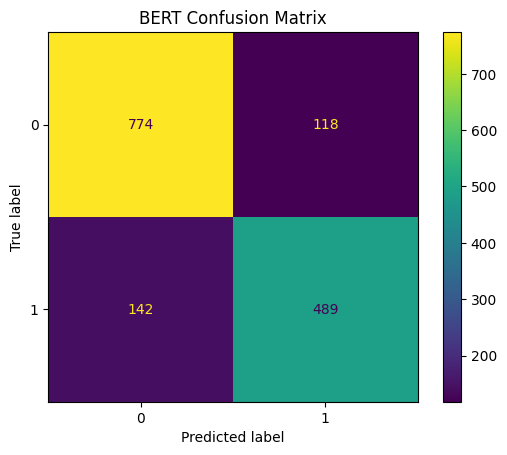

In [ ]:
ConfusionMatrixDisplay(confusion_matrix(y_val,preds)).plot()
plt.title('BERT Confusion Matrix')
plt.savefig('bert_conf_matrix.png', dpi=200, bbox_inches='tight');

from google.colab import files
files.download("bert_conf_matrix.png")

#Sample predictions from test set

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving test_sample.csv to test_sample.csv


In [ ]:
sample_tweets = pd.read_csv(io.BytesIO(uploaded['test_sample.csv']))
sample_tweets = sample_tweets.drop(['Unnamed: 0', 'Unnamed: 4','Unnamed: 3', 'Unnamed: 5', 'Unnamed: 6'],axis=1)
sample_tweets

,text,target
0,"Heard about #earthquake is different cities, s...",1
1,@Kayhow21 I may have a panic attack during thi...,0
2,Fire shuts down part of NJ Turnpike å_ 96 http...,1
3,'Sometimes I close my eyes and picture what th...,0
4,i survived what you tried to destroy you're no...,0
5,Green Line derailment in Chicago http://t.co/U...,1


In [ ]:
# Encode our data
encoded_tweets = [tokenizer.encode(sent, add_special_tokens=True) for sent in np.array(sample_tweets['text'])]

# Find the maximum length
max_len = max([len(sent) for sent in encoded_tweets])
print('Max length: ', max_len)

Max length:  43


In [ ]:
warnings.filterwarnings('ignore')
# Specify `MAX_LEN`
MAX_LEN = 43

# Print sentence 0 and its encoded token ids
print('Original: ', sample_tweets['text'][0])
print('Token IDs: ', list(preprocessing_for_bert([sample_tweets['text'][0]])[0].squeeze().numpy()))
print("Attention Mask: ",list(preprocessing_for_bert([sample_tweets['text'][0]])[1].squeeze().numpy()))

# Run function `preprocessing_for_bert` on the train set and the validation set
print('Tokenizing data...')
test_inputs, test_masks = preprocessing_for_bert(sample_tweets['text'])


Original:  Heard about #earthquake is different cities, stay safe everyone.
Token IDs:  [101, 2657, 2055, 8372, 2003, 2367, 3655, 2994, 3647, 3071, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Attention Mask:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Tokenizing data...


In [ ]:
test_labels = torch.tensor(sample_tweets['target'])

batch_size = 6

test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=6)

In [ ]:
def get_predictions(model, test_dataloader):
    """After the completion of each training epoch, measure the model's performance
    on our validation set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    # Tracking variables
    test_accuracy = []
    test_f1_score = []
    test_loss = []

    # For each batch in our validation set...
    for batch in test_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)

        # Compute loss
        loss = loss_fn(logits, b_labels)
        test_loss.append(loss.item())

        # Get the predictions
        preds = torch.argmax(logits, dim=1).flatten()

        # Calculate the accuracy rate
        accuracy = (preds == b_labels).cpu().numpy().mean() * 100
        test_accuracy.append(accuracy)

        # Calculate the f1 score
        tp = torch.tensor((preds == 1) & (b_labels == 1)).cpu().numpy().sum()
        fp = torch.tensor((preds == 1) & (b_labels == 0)).cpu().numpy().sum()
        fn = torch.tensor((preds == 0) & (b_labels == 1)).cpu().numpy().sum()
        f1_score = torch.tensor((2*tp)/(2*tp + fp + fn)).cpu().numpy().mean()*100
        test_f1_score.append(f1_score)

    # Compute the average accuracy and loss over the validation set.
    test_loss = np.mean(test_loss)
    test_accuracy = np.mean(test_accuracy)
    test_f1_score = np.mean(test_f1_score)

    print(f'Predictions: {preds}')
    print(f'Accuracy: {test_accuracy}')
    print(f'F1-Score:{test_f1_score}')


In [ ]:
get_predictions(bert_classifier, test_dataloader)

Predictions: tensor([1, 0, 1, 0, 0, 1], device='cuda:0')
Accuracy: 100.0
F1-Score:100.0
